     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Total Malignant: 1954, Total Benign: 8061


100%|██████████| 10015/10015 [02:25<00:00, 68.68it/s]


Image preprocessing done.


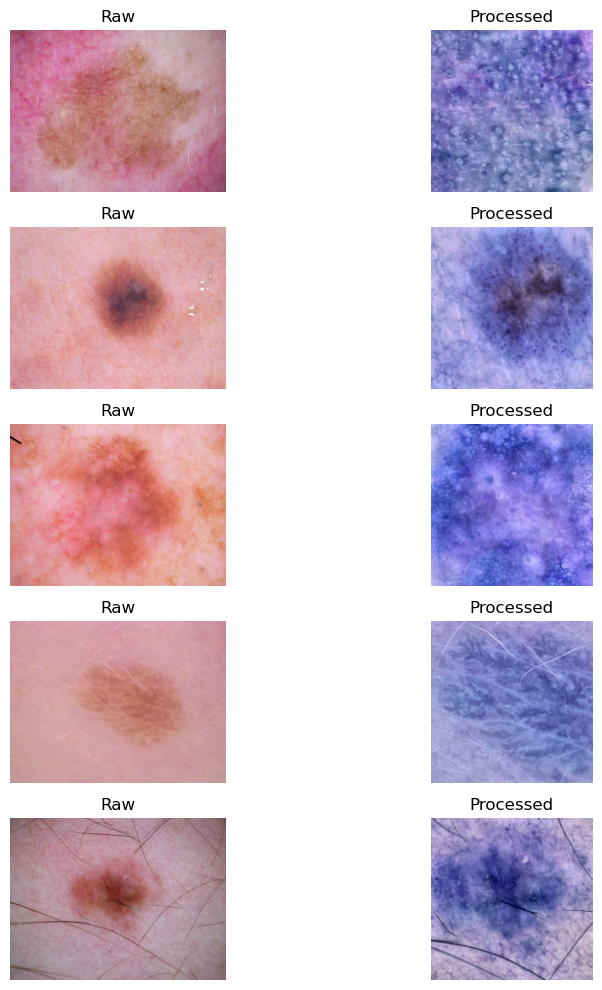

Training malignant: 1563, Training benign: 6449
Testing malignant: 391, Testing benign: 1612
Class Weights: {0: 0.6211815785393084, 1: 2.563019833653231}
Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.5980 - loss: 0.6915 - val_accuracy: 0.7534 - val_loss: 0.4851
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7182 - loss: 0.5443 - val_accuracy: 0.7479 - val_loss: 0.4776
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.7350 - loss: 0.5153 - val_accuracy: 0.7514 - val_loss: 0.4621
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.7420 - loss: 0.4937 - val_accuracy: 0.7474 - val_loss: 0.4690
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7409 - loss: 0.4928 - val_accuracy: 0.7424 - val_loss: 0.4743
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7544 - loss: 0.4794 - val_accuracy: 0.7399 - val_loss: 0.4713
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.7540 

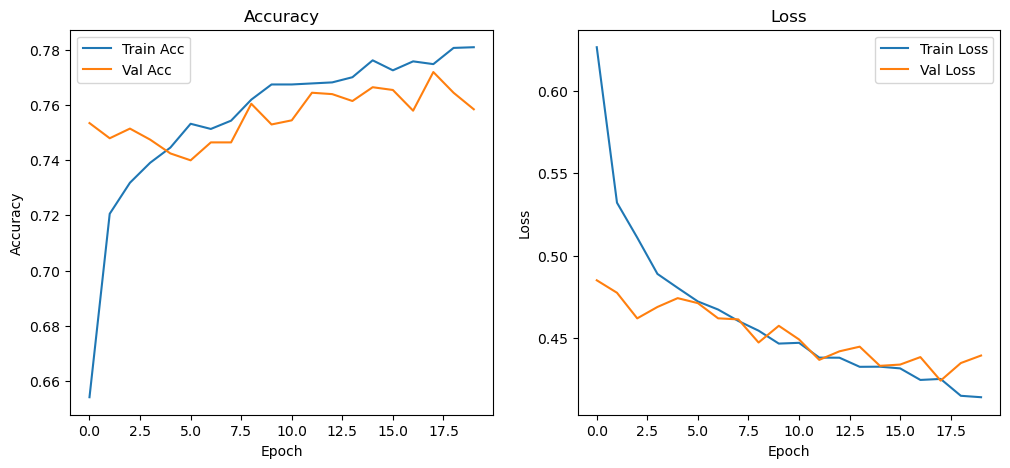

63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 958ms/step - accuracy: 0.7704 - loss: 0.4197
Test Accuracy: 75.84%
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 978ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.83      1612
           1       0.43      0.77      0.55       391

    accuracy                           0.76      2003
   macro avg       0.68      0.76      0.69      2003
weighted avg       0.83      0.76      0.78      2003



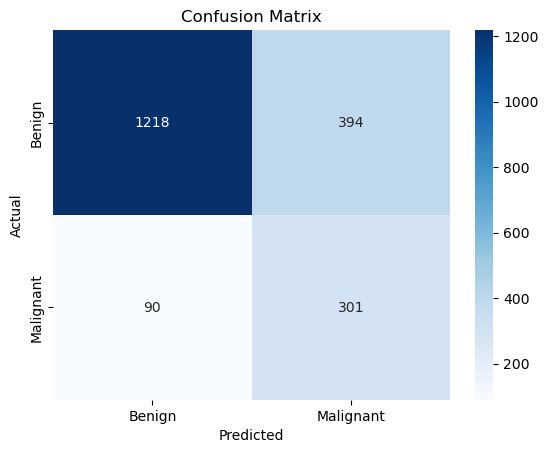

63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 978ms/step


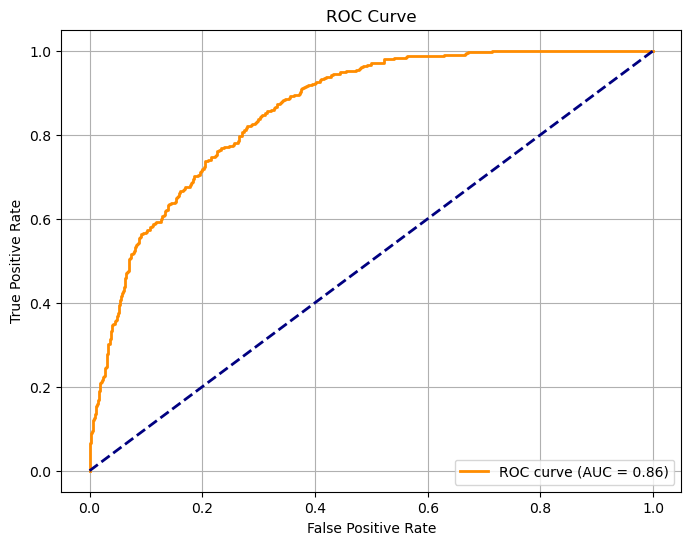

In [5]:
# Skin Cancer Detection Using CNN and Image Processing

# ## Description
# This project uses a Convolutional Neural Network (MobileNetV2) to classify
# skin cancer images as benign or malignant. Various preprocessing techniques
# such as color normalization, segmentation, and augmentation are applied
# to study their impact on classification performance.

# ## Dataset
# HAM10000 – Human Against Machine with 10000 training images.

# ## Author
# Man-w-Salwa Qazi

import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# --- Load metadata ---
df = pd.read_csv('skin-cancer-detection-cnn/data/HAM10000_metadata.csv')
print(df.head())

# --- Label malignant vs benign ---
malignant_classes = ['akiec', 'bcc', 'mel']
df['label'] = df['dx'].apply(lambda x: 1 if x in malignant_classes else 0)

print(f"Total Malignant: {(df['label']==1).sum()}, Total Benign: {(df['label']==0).sum()}")

# --- Add image paths & filter missing images ---
df['image_path'] = df['image_id'].apply(lambda x: f"./data/images/{x}.jpg")
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# --- Create processed images folder ---
os.makedirs("processed_images", exist_ok=True)

# --- Preprocessing functions ---

# === 1. Color Normalization ===
def normalize_color(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
# === 2. Segmentation (Cropping) ===
def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    return img[starty:starty+cropy, startx:startx+cropx]

# === 3. Data Augmentation ===
def augment_image(img):
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    if np.random.rand() > 0.5:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img
    
# === 4. Final Preprocessing Pipeline ===
def preprocess_image(img_path, size=(224, 224)):
    img = cv2.imread(img_path)
    img = crop_center(img, 250, 250)
    img = normalize_color(img)
    img = augment_image(img)
    img = cv2.resize(img, size)
    img = img / 255.0
    return img

# --- Preprocess and save images ---
df['processed_path'] = ""

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img = preprocess_image(row['image_path'])
        filename = os.path.basename(row['image_path']).replace(".jpg", "")
        save_path = f"./processed_images/{filename}_processed.jpg"
        cv2.imwrite(save_path, (img * 255).astype(np.uint8))
        df.at[i, 'processed_path'] = save_path
    except Exception as e:
        print(f"Error processing {row['image_path']}: {e}")

df.to_csv("HAM10000_processed_updated.csv", index=False)
print("Image preprocessing done.")

# --- Visualization of raw vs processed ---
sample_df = df.sample(5, random_state=42)

plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_df.itertuples()):
    raw = cv2.cvtColor(cv2.imread(row.image_path), cv2.COLOR_BGR2RGB)
    processed = cv2.cvtColor(cv2.imread(row.processed_path), cv2.COLOR_BGR2RGB)

    plt.subplot(5, 2, 2*i+1)
    plt.imshow(raw)
    plt.title("Raw")
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed)
    plt.title("Processed")
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- Train-test split ---
X = df['processed_path'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training malignant: {sum(y_train)}, Training benign: {len(y_train)-sum(y_train)}")
print(f"Testing malignant: {sum(y_test)}, Testing benign: {len(y_test)-sum(y_test)}")

# --- TF Dataset creation ---
IMG_SIZE = 224

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

# --- Compute class weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# --- Build model ---
def build_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# --- Train model ---
history = model.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# --- Evaluate model ---
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

# Get predictions and true labels for classification report and confusion matrix
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

y_true = np.concatenate([y for _, y in test_ds], axis=0)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
y_prob = model.predict(test_ds).ravel()
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
